In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder
import pickle
import joblib

In [256]:
CLN_DATA_PATH='../data/codon_df_clean.csv'

try:
    codon_df_clean = pd.read_csv(CLN_DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: The data file does not exist.")

Data loaded successfully.


## Introduction


In this notebook, we will explore and compare several machine learning models for classifying codon frequencies into different biological kingdoms. Codons, which are sequences of three nucleotides, play a critical role in the genetic coding of proteins. The frequency of these codons can provide valuable insights into the biological origins of different species.

The primary objective of this study is to evaluate the performance of various machine learning algorithms in accurately classifying rows of codon frequencies into their respective biological kingdoms. We aim to determine which model offers the best performance in terms of accuracy, recall, and overall score.

In [ ]:
#label encoder as an alternative to group de kingdoms
#kingdom_mapped = ['vrl', 'arc', 'bct', 'phg', 'plm', 'pln', 'inv', 'vrt', 'mam', 'rod', 'pri' ]
#label_encoder = LabelEncoder()

#codon_df_clean['Kingdom_labels'] = label_encoder.fit_transform(codon_df_clean['Kingdom'])
#codon_df_clean[['Kingdom_labels','Kingdom']].value_counts()


In [257]:
#separate the kingdoms into five, this is closer to the biological kingdoms
codon_df_clean['Kingdom'] = codon_df_clean['Kingdom'].replace({
    'vrl': 'virus',
    'phg': 'virus',
    'vrt': 'animalia',
    'pln': 'plantae',
    'bct': 'bacteria',
    'arc': 'archaea',
    'inv': 'animalia',
    'mam': 'animalia',
    'rod': 'animalia',
    'pri': 'animalia'
})


In [258]:
codon_df_clean = codon_df_clean[codon_df_clean['Kingdom'] != 'plm']

## Bayes model 


In [259]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [260]:
# Drop non-feature columns from the dataframe to create the feature set X
# The columns 'Kingdom_labels', 'SpeciesName', 'Kingdom', and 'SpeciesID' are removed
X = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'Kingdom', 'SpeciesID'])

# Extract the target variable 'Kingdom_labels' to create the label set y
y= codon_df_clean['Kingdom']

# Split the data into training and testing sets
# 20% of the data is reserved for testing, and the rest is used for training
# The random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [261]:
# Initialize the StandardScaler, which will standardize the features by removing the mean and scaling to unit variance
scaler_GNB = StandardScaler()

# Fit the scaler on the training data (learn the scaling parameters)
scaler_GNB.fit(X_train)

# Transform the training and test data using the fitted scaler
X_train_scaled = scaler_GNB.transform(X_train)
X_test_scaled = scaler_GNB.transform(X_test)

In [262]:
# Initialize the Gaussian Naive Bayes classifier
bayes = GaussianNB()

# Fit the Naive Bayes model on the scaled training data
bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [263]:
print(f'Accuracy on train set: {bayes.score(X_train, y_train)}')
print(f'Accuracy on test set: {bayes.score(X_test, y_test)}')

Accuracy on train set: 0.3379780895637132
Accuracy on test set: 0.33512682551883166


c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [264]:
# Predict the labels for the training and test data
y_train_pred = bayes.predict(X_train_scaled)
y_test_pred = bayes.predict(X_test_scaled)

In [265]:
# Generate a classification report for the training data predictions
report_train_GNB = classification_report(y_train, y_train_pred)
print(report_train_GNB)

              precision    recall  f1-score   support

    animalia       0.96      0.64      0.77      3517
     archaea       0.23      0.74      0.35       102
    bacteria       0.69      0.50      0.58      2343
     plantae       0.78      0.43      0.56      2005
       virus       0.45      0.92      0.61      2439

    accuracy                           0.64     10406
   macro avg       0.62      0.65      0.57     10406
weighted avg       0.74      0.64      0.64     10406



In [266]:
report_test_GNB = classification_report(y_test, y_test_pred)
print(report_test_GNB)

              precision    recall  f1-score   support

    animalia       0.95      0.65      0.77       872
     archaea       0.20      0.67      0.31        24
    bacteria       0.72      0.53      0.61       576
     plantae       0.76      0.45      0.56       518
       virus       0.47      0.92      0.62       612

    accuracy                           0.65      2602
   macro avg       0.62      0.64      0.58      2602
weighted avg       0.74      0.65      0.65      2602



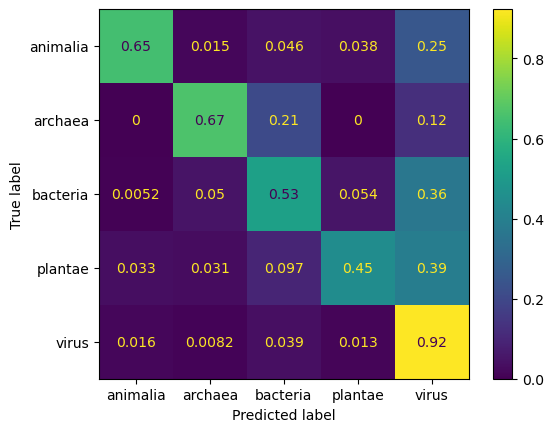

In [269]:
# Compute the confusion matrix for the test data predictions
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay.from_estimator(bayes, X_test_scaled, y_test, normalize='true') 


In [363]:
joblib.dump(bayes, '../model/bayes_model.pkl') 

['../model/bayes_model.pkl']

Accuracy: The overall accuracy of the model is 65%. This means that 65% of the predictions made by the model are correct.

For the Animalia kingdom there is a high precision but relatively lower recall. The model is very good at predicting the positive instances of Animalia but misses quite a few actual instances.

Very low precision for Archaea but high recall. The model often predicts Archaea when it is not, but it is able to capture most of the actual Archaea instances.

Fairly balanced precision and recall for Bacteria, but both are moderate. The model has a decent but not outstanding ability to predict this kingdom

Good precision but lower recall for Plantae. The model predicts  correctly when it does, but misses more than half of the actual Plantae instances.

Lower precision but very high recall for the kingdom Virus Bact. The model captures most of the instances but also makes many false positives.

There is a clear trade-off between precision and recall in many classes, indicating that the model might be more tuned towards capturing as many instances as possible (high recall) at the expense of precision (more false positives).



## Logistic Regression


In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

In [271]:
# Split the data into training and testing sets
X_1 = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_1= codon_df_clean['Kingdom']


X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X_1, y_1, test_size=0.2, random_state=34)

In [272]:
print(X_train_lg.shape)
print (y_train_lg.shape)

(10406, 66)
(10406,)


In [273]:
#We define a list of steps (estimators) for our pipeline.
estimators_lg = [('normalise', StandardScaler()), #removing the mean and scaling to unit variance
              ('reduce_dim', PCA()),
              ('lg', LogisticRegression(n_jobs=4, random_state=34, max_iter=10000))]

pipe_lg = Pipeline(estimators_lg)
print(pipe_lg)

Pipeline(steps=[('normalise', StandardScaler()), ('reduce_dim', PCA()),
                ('lg',
                 LogisticRegression(max_iter=10000, n_jobs=4,
                                    random_state=34))])


In [274]:
n_components = list(range(60, 65, 1))

# params for LogisticRegression()
# C values
C = [0.001, 0.01, 0.1, 1, 10, 100] 

#define the parameter grid
params_lg = dict(
    reduce_dim__n_components = n_components,
    lg__C = C,
)
print(f"parameter grid values: {params_lg}")

parameter grid values: {'reduce_dim__n_components': [60, 61, 62, 63, 64], 'lg__C': [0.001, 0.01, 0.1, 1, 10, 100]}


In [275]:
#GridSearchCV to search for the best hyperparameters for the pipeline
grid_search_lg = GridSearchCV(pipe_lg, param_grid=params_lg, cv=5, scoring='accuracy')

#fit the GridSearchCV object to the training data
grid_search_lg.fit(X_train_lg, y_train_lg)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('reduce_dim', PCA()),
                                       ('lg',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=4,
                                                           random_state=34))]),
             param_grid={'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'reduce_dim__n_components': [60, 61, 62, 63, 64]},
             scoring='accuracy')

In [276]:
best_model_lg = grid_search_lg.best_estimator_
print(grid_search_lg.best_estimator_.get_params()['reduce_dim__n_components'])
print(grid_search_lg.best_estimator_.get_params()['lg__C'])
print(best_model_lg)

63
1
Pipeline(steps=[('normalise', StandardScaler()),
                ('reduce_dim', PCA(n_components=63)),
                ('lg',
                 LogisticRegression(C=1, max_iter=10000, n_jobs=4,
                                    random_state=34))])


The grid search process identified the following optimal parameters:

PCA: n_components=63, which balances the trade-off between retaining variance and reducing dimensionality.Although in this case it seems it need almost all of them. 

Logistic Regression:
C=1, indicating less regularization and allowing a closer fit to the training data.

This configuration is expected to improve model accuracy and efficiency based on the results of the grid search.

In [277]:
y_pred_lg = best_model_lg.predict(X_test_lg)
accuracy_lg = accuracy_score(y_test_lg, y_pred_lg)
print(f"Test set accuracy: {accuracy_lg}")
print(classification_report(y_test_lg, y_pred_lg))


Test set accuracy: 0.898923904688701
              precision    recall  f1-score   support

    animalia       0.91      0.90      0.91       872
     archaea       0.85      0.71      0.77        24
    bacteria       0.94      0.94      0.94       576
     plantae       0.87      0.85      0.86       518
       virus       0.87      0.91      0.89       612

    accuracy                           0.90      2602
   macro avg       0.89      0.86      0.87      2602
weighted avg       0.90      0.90      0.90      2602



In [278]:
best_model_lg.named_steps['lg'].coef_


array([[-2.91163374e-01,  9.80448918e-01,  7.58026614e-02,
         8.73153155e-01,  4.85798491e-01, -7.26640083e-01,
        -5.63942893e-01,  1.95511372e-02,  7.97337219e-01,
         4.34699759e-02,  8.02179365e-01, -1.10423287e+00,
         7.15116173e-01, -4.30760940e-01, -1.36674601e-01,
         3.82628468e-01,  1.50347846e-01,  5.41918761e-01,
         6.30878493e-01, -6.56103365e-01,  7.18298225e-01,
         1.06918179e+00, -2.19890378e-03, -3.69043293e-01,
         7.47947982e-01, -2.16833574e-01,  6.53615705e-01,
        -7.56032597e-01, -1.59248390e-01, -2.29169229e-01,
        -7.73806042e-01,  7.46320488e-01,  7.70899391e-01,
         1.65935004e+00, -6.13459784e-01, -2.13849338e-01,
        -2.82531385e-01, -6.57426653e-01,  9.13370667e-02,
         3.49521653e-01,  8.52708030e-01,  6.54635410e-01,
        -1.41430090e-01, -2.91448888e-01,  2.56668355e-01,
         2.49612123e-01,  3.86801615e-01, -7.35927737e-02,
        -3.83831188e-01, -5.38058598e-01, -9.51698418e-0

Larger coefficients show how important those features are for the classification. 

A positive coefficient means that as the principal component increases, the log-odds of the corresponding class increase, making it more likely. A negative coefficient means the opposite.

In [279]:
#best_model_lg is our fitted pipeline
coefficients = best_model_lg.named_steps['lg'].coef_

# class names
class_names = ['Animalia', 'Archaea', 'Bacteria', 'Plantae', 'Virus_Bacteriophage']

# Creating a DataFrame for better visualization
coef_df = pd.DataFrame(coefficients, columns=[f'PC{i+1}' for i in range(coefficients.shape[1])], index=class_names[:])

# Display the DataFrame
print(coef_df)

                          PC1       PC2       PC3       PC4       PC5  \
Animalia            -0.291163  0.980449  0.075803  0.873153  0.485798   
Archaea              0.071751  0.235769 -0.127776 -0.681810 -0.940807   
Bacteria             0.324638 -0.307359 -0.712746 -1.352584 -0.239702   
Plantae             -0.241236 -0.211313 -0.224906  0.910062  1.339460   
Virus_Bacteriophage  0.136011 -0.697546  0.989625  0.251180 -0.644749   

                          PC6       PC7       PC8       PC9      PC10  ...  \
Animalia            -0.726640 -0.563943  0.019551  0.797337  0.043470  ...   
Archaea              1.079990  0.103229  0.896535 -0.356843 -0.359115  ...   
Bacteria             0.693636  0.317342 -0.135685 -0.230382 -0.195520  ...   
Plantae             -1.269462 -0.133566  0.011232 -0.003186 -0.407297  ...   
Virus_Bacteriophage  0.222477  0.276938 -0.791633 -0.206927  0.918462  ...   

                         PC54      PC55      PC56      PC57      PC58  \
Animalia           

Animalia and Bacteria have coefficients with larger magnitudes for certain PCs, suggesting these PCs have a strong influence on the prediction.

Archaea shows variability across PCs, but given the small sample size, this might require further validation.

Virus and Plantae also show significant coefficients across different PCs


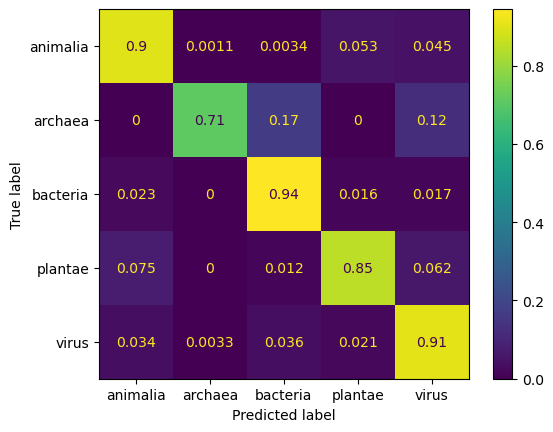

In [281]:
cm = confusion_matrix(y_test_lg, y_pred_lg)
ConfusionMatrixDisplay.from_estimator(best_model_lg, X_test_lg, y_test_lg, normalize='true')



In [364]:
joblib.dump(best_model_lg, '../model/LG_model.pkl') 

['../model/LG_model.pkl']

The overall accuracy of the model is 90%. This means that 90% of the predictions made by the model are correct.

High precision and recall for Animalia, indicating that the model is both accurate and reliable in predicting them.

Improved precision and recall for Archaea compared to the Gaussian Naive Bayes model, though recall is still relatively lower due to the small number of instances.

Great performance with high precision and recall for Bacteria, indicating the model's strong ability to predict this class.

High precision and recall, showing reliable performance in predicting Plantae.

Strong performance with high precision and recall, indicating the model's effectiveness in predicting Virus Bacteriophage.

The Logistic Regression model shows a substantial improvement in all metrics compared to the Gaussian Naive Bayes model. This suggests that Logistic Regression, combined with standard scaling and PCA, is more suitable for this data.

The class Archaea still has lower recall, likely due to the small number of instances. For future if techniques like oversampling or synthetic data generation to balance the dataset.


## KNN

In [282]:
from sklearn.neighbors import KNeighborsClassifier

In [283]:
X_2 = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_2= codon_df_clean['Kingdom']


X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_2, y_2, test_size=0.2, random_state=34)

In [284]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [285]:
grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=4, scoring='accuracy')
grid_search_knn.fit(X_train_knn, y_train_knn)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 10],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [286]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [287]:
best_model_knn = grid_search_knn.best_estimator_

# Evaluate the model on the test set
y_pred_knn = best_model_knn.predict(X_test_knn)
accuracy = accuracy_score(y_test_knn, y_pred_knn)
print(f"Test set accuracy: {accuracy}")
print(classification_report(y_test_knn, y_pred_knn))


Test set accuracy: 0.9554189085318986
              precision    recall  f1-score   support

    animalia       0.97      0.96      0.96       872
     archaea       0.91      0.88      0.89        24
    bacteria       0.95      0.97      0.96       576
     plantae       0.94      0.95      0.94       518
       virus       0.96      0.95      0.95       612

    accuracy                           0.96      2602
   macro avg       0.95      0.94      0.94      2602
weighted avg       0.96      0.96      0.96      2602



In [288]:
train_accuracy1 = best_model_knn.score(X_train_knn, y_train_knn)
train_accuracy1

1.0

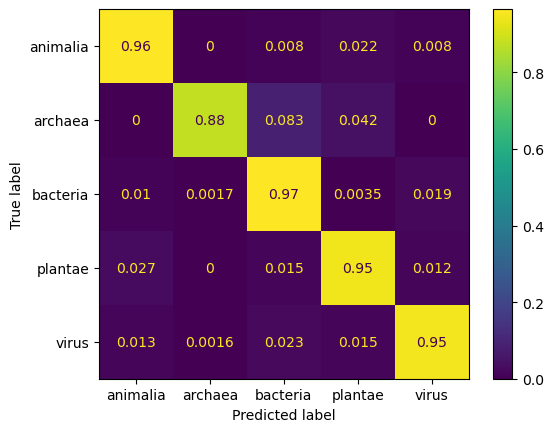

In [296]:
cm_test = confusion_matrix(y_test_knn, y_pred_knn)
ConfusionMatrixDisplay.from_estimator(best_model_knn, X_test_knn, y_test_knn, normalize='true') #, cmap=plt.cm.Blues)


In [297]:
cv_scores_knn = cross_val_score(best_model_knn, X_2, y_2, cv=5)
print(f"Cross-validation scores: {cv_scores_knn}")
print(f"Mean cross-validation score: {cv_scores_knn.mean()}")

Cross-validation scores: [0.86433513 0.93889316 0.96848578 0.96309112 0.8958093 ]
Mean cross-validation score: 0.9261228978034521


In [365]:
joblib.dump(best_model_knn, '../model/KNN_model.pkl') 

['../model/KNN_model.pkl']

This indicates that 96% of the predictions made by the model are correct.

Very high precision and recall for Animalia, indicating that the model is extremely accurate and reliable in predicting these class.

Significant improvement in precision and recall for Archaea compared to previous models, despite the small number of instances.

Excellent performance with very high precision and recall for BActeria, indicating the model's strong ability to predict this kingdom.

High precision and recall, showing reliable performance in predicting Plantae.

Very high precision and recall, indicating the model's effectiveness in predicting Virus Bacteriophage.

The KNN model with the chosen parameters has outperformed both the Gaussian Naive Bayes and Logistic Regression models in terms of accuracy, precision, recall, and F1-score across almost all classes.

The class Archaea still has lower support but performs significantly better with the KNN model. The improved performance may be due to the model's ability to use distance metrics effectively to identify and classify these rare instances.

This improvement might come from the fact KNN can model non-linear decisions which logistic regression can’t.

While KNN can benefit from standard scaling, the use of the Manhattan distance metric and the model's performance suggest that the scaling and parameter choices are effective. PCA may or may not be necessary depending on the context, but it does not seem to affect performance here.

## Random Forest

In [298]:
from sklearn.ensemble import RandomForestClassifier

In [299]:
X_3 = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_3= codon_df_clean['Kingdom']


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_3, y_3, test_size=0.2, random_state=34)

In [300]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=34))
])

In [301]:
param_grid_rf = {
    'pca__n_components': [55, 64],
    'rf__n_estimators': [200, 300, 350],
    'rf__max_depth': [30, 35],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

In [302]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=4, scoring='accuracy')
grid_search_rf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rf',
                                        RandomForestClassifier(random_state=34))]),
             n_jobs=4,
             param_grid={'pca__n_components': [55, 64],
                         'rf__max_depth': [30, 35],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [200, 300, 350]},
             scoring='accuracy')

In [303]:
print("Best parameters found: ", grid_search_rf.best_params_)

Best parameters found:  {'pca__n_components': 64, 'rf__max_depth': 35, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 350}


In [304]:
best_model_rf = grid_search_rf.best_estimator_

# Evaluate the model on the test set
y_pred_rf = best_model_rf.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
print(f"Test set accuracy: {accuracy_rf}")
print(classification_report(y_test_rf, y_pred_rf))


Test set accuracy: 0.9377401998462721
              precision    recall  f1-score   support

    animalia       0.95      0.95      0.95       872
     archaea       1.00      0.50      0.67        24
    bacteria       0.92      0.97      0.94       576
     plantae       0.94      0.91      0.93       518
       virus       0.93      0.94      0.93       612

    accuracy                           0.94      2602
   macro avg       0.95      0.85      0.88      2602
weighted avg       0.94      0.94      0.94      2602



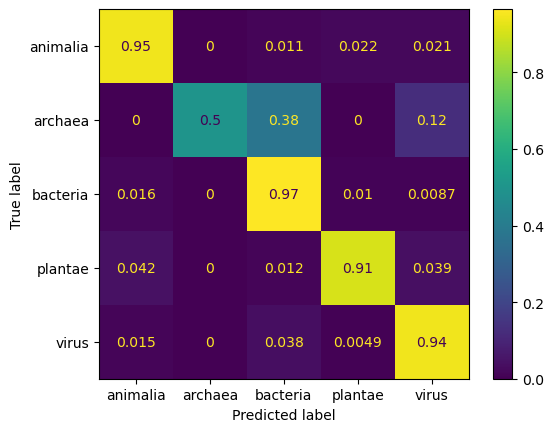

In [305]:
rf_test = confusion_matrix(y_test_rf, y_pred_rf)
ConfusionMatrixDisplay.from_estimator(best_model_rf, X_test_rf, y_test_rf, normalize='true')


The overall accuracy of the model is 94%. This is the highest accuracy achieved so far. 

Very high precision and recall for Animalia. The model is extremely effective at predicting them with minimal errors.

100 % precision but relatively low recall for Archaea. The model predicts their instances very accurately when it does, but it misses more than half of the actual instances, possibly due to the small sample size.

The model is highly reliable for predicting Bacteria.

High precision and recall, indicating that the model predicts Plantae and Virus Bact accurately with minimal errors.

The use of PCA with 63 components in combination with Random Forest appears effective, suggesting that PCA helps in capturing the most informative features for this model.

The model performs well across all classes, though Archaea still presents a challenge. 

In [366]:
joblib.dump(best_model_rf, '../model/RF_model.pkl') 

['../model/RF_model.pkl']

In [306]:
from sklearn import tree
from sklearn.tree import plot_tree

In [307]:
best_rf = best_model_rf.named_steps['rf']
n_components = best_model_rf.named_steps['pca'].n_components_
feature_names = [f'PC{i+1}' for i in range(n_components)]
importances = best_rf.feature_importances_

In [308]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

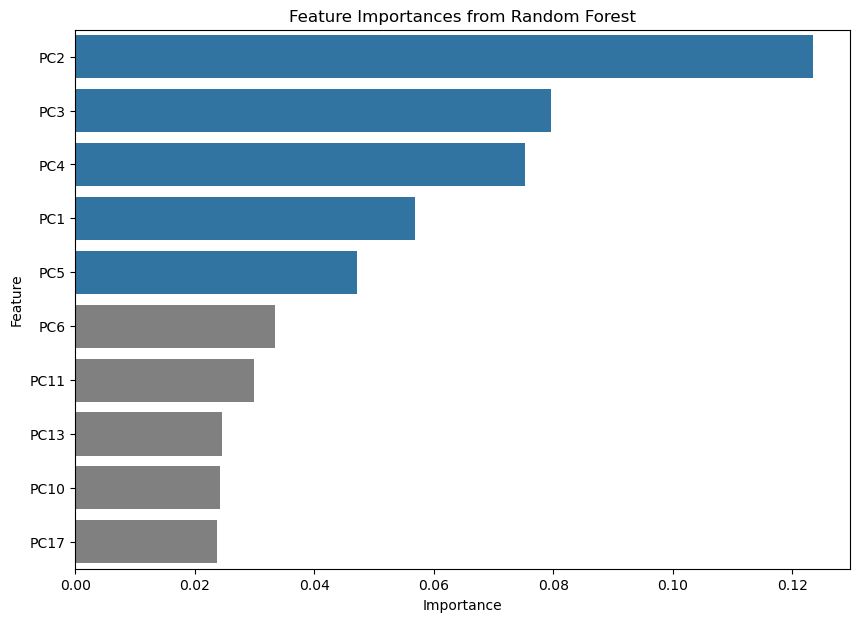

In [309]:
top_10_features = feature_importance_df.head(10)
palette = ['#1f77b4' if i < 5 else 'gray' for i in range(len(feature_importance_df))]
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette=palette)
plt.title('Feature Importances from Random Forest')
plt.show()

The feature importance analysis using PCA components indicates that the top five principal components (PCs) contributing to the classification task are PC2, PC3, PC4, PC1, and PC5. This information is useful for understanding which features (or combinations of features) are most influential in the model's decision-making process.

In [310]:
scaler_for_PCA = StandardScaler()
X_train_rf_scaled = scaler_for_PCA.fit_transform(X_train_rf)

In [311]:
pca_rf = PCA(n_components=63)
pca_rf.fit(X_train_rf_scaled)
pca_rf.components_

array([[-0.08673958,  0.01497682, -0.16375614, ..., -0.05811663,
        -0.00225591, -0.03786751],
       [ 0.12278695, -0.01590893, -0.01830916, ...,  0.06103592,
        -0.01070072,  0.25976303],
       [-0.19799315, -0.04314577, -0.20073386, ...,  0.01251046,
         0.04394399, -0.0639423 ],
       ...,
       [ 0.03022132,  0.00044333, -0.38090062, ...,  0.02886844,
        -0.00956205, -0.00267507],
       [ 0.01895869,  0.00222016, -0.02168902, ..., -0.02988907,
        -0.0133879 ,  0.42169053],
       [ 0.01371835, -0.00098464, -0.01127053, ...,  0.01085079,
         0.00438635, -0.29881626]])

Each principal component represents a linear combination of the original features. The importance of each PC indicates how much variance it explains in the data and how influential it is in making predictions.PC2, PC3, PC4, and PC5 might capture specific relationships between the original features that are more directly relevant to distinguishing between the biological kingdoms.

In [312]:
loadings = pca_rf.components_
loadings_df = pd.DataFrame(loadings, columns=X_train_rf.columns)

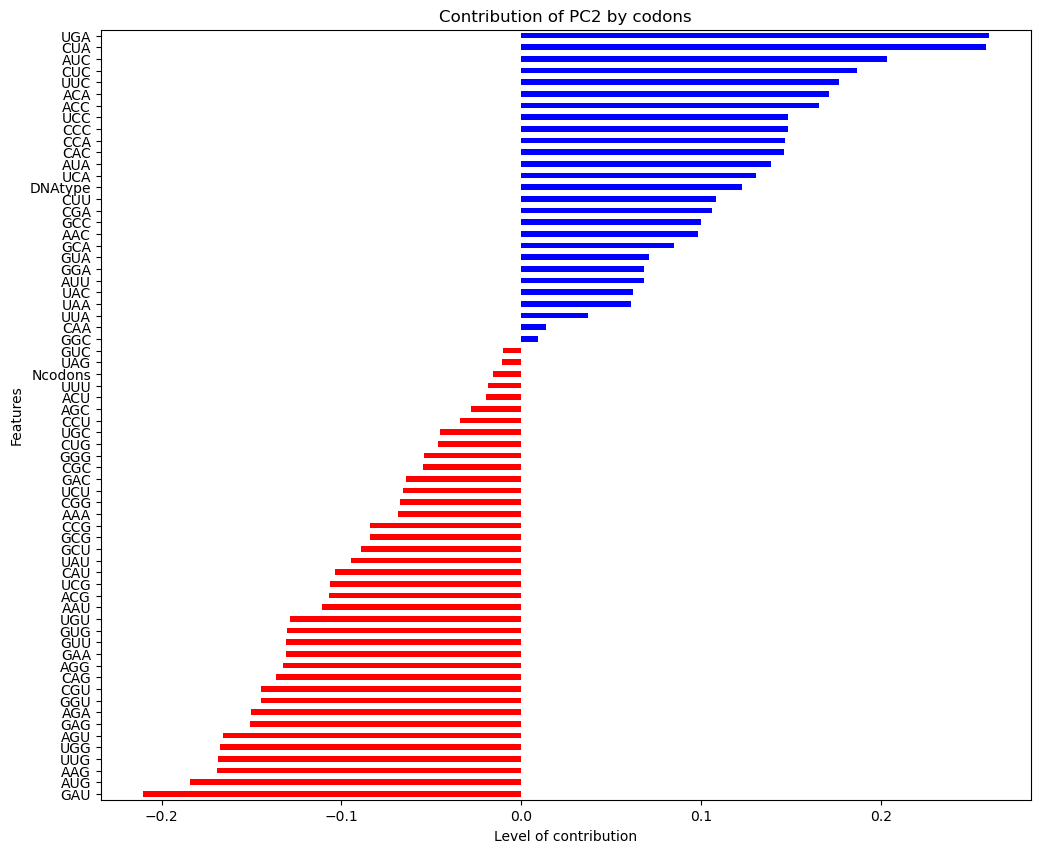

In [395]:
# Selecting PC2 
pc2_loadings = loadings_df.iloc[1, :].sort_values()

# Determine colors 
colors = ['red' if x < 0 else 'blue' for x in pc2_loadings]

plt.figure(figsize=(12,10))
pc2_loadings.plot(kind='barh', color=colors)
plt.ylabel('Features')
plt.xlabel('Level of contribution')
plt.title('Contribution of PC2 by codons')
plt.show()

A positive contribution above 0.2 for UGA and CUA in PC2 means that as the usage of these codons increases, the PC2 score increases as well. This could correlate with specific kingdoms where these codons are more prevalent.

A negative contribution of -0.2 for GAU indicates that higher usage of GAU decreases the PC2 score. This might be indicative of kingdoms where GAU is less prevalent or has a different functional significance.

The **biological** context of these codons can provide further insights:

UGA: Often serves as a stop codon in the genetic code, which can have implications in gene expression and protein synthesis.

CUA: Codes for the amino acid leucine and might be prevalent in certain genomes.

GAU: Codes for the amino acid aspartic acid and its usage might vary across different species.

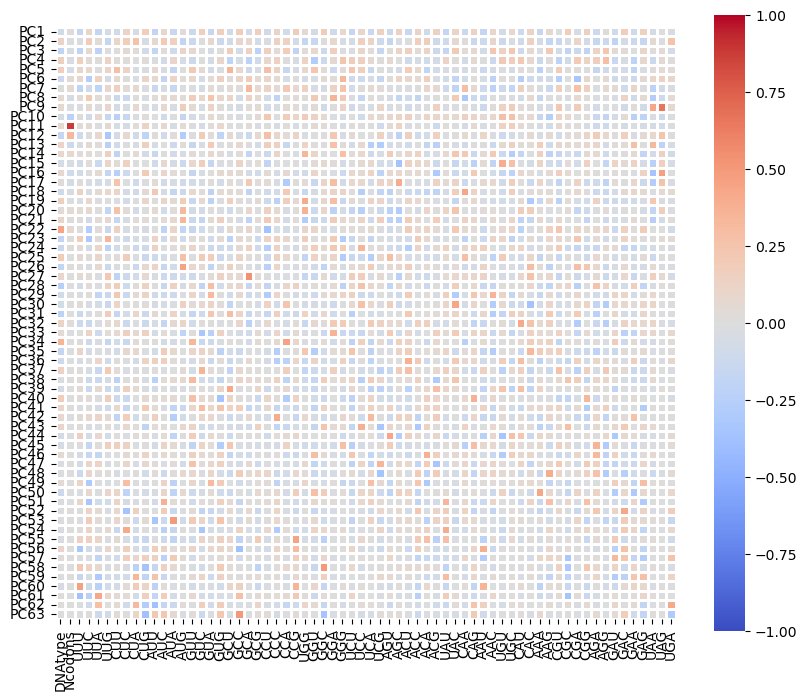

In [314]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(pca_rf.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PC"+str(x) for x in range(1,pca_rf.n_components_+1)],
                 xticklabels=list(X_train_rf.columns[:]),
                 linewidths = 1,
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_aspect("equal")
plt.show()

Relationship between the PCs and all the condons. This is hard to interpret but nevertheless its possible to apreciate some level of relationship. 

In [315]:
expl_variance = pca_rf.explained_variance_ratio_

cumulative_sum = np.cumsum(expl_variance)
#cumulative_sum
expl_variance.round(4)

array([0.2914, 0.1836, 0.0559, 0.0398, 0.0336, 0.0294, 0.0229, 0.0218,
       0.0175, 0.0162, 0.015 , 0.0141, 0.0136, 0.0126, 0.0123, 0.0118,
       0.0116, 0.01  , 0.0095, 0.0091, 0.0082, 0.0077, 0.0075, 0.0072,
       0.0068, 0.0066, 0.0059, 0.0057, 0.0056, 0.0053, 0.0053, 0.0051,
       0.0048, 0.0046, 0.0044, 0.0041, 0.004 , 0.0038, 0.0037, 0.0037,
       0.0035, 0.0034, 0.0033, 0.0032, 0.0031, 0.003 , 0.0029, 0.0027,
       0.0026, 0.0026, 0.0024, 0.0024, 0.0023, 0.0023, 0.0021, 0.0019,
       0.0019, 0.0017, 0.0017, 0.0017, 0.0016, 0.0015, 0.0014])

First Principal Component (PC1): Explains 29.14% of the variance.

Second Principal Component (PC2): Explains 18.36% of the variance.

Third Principal Component (PC3): Explains 5.59% of the variance.

The first three PCs together explain 53.09% of the variance. This indicates that more than half of the dataset's variance can be captured with just the first three components.

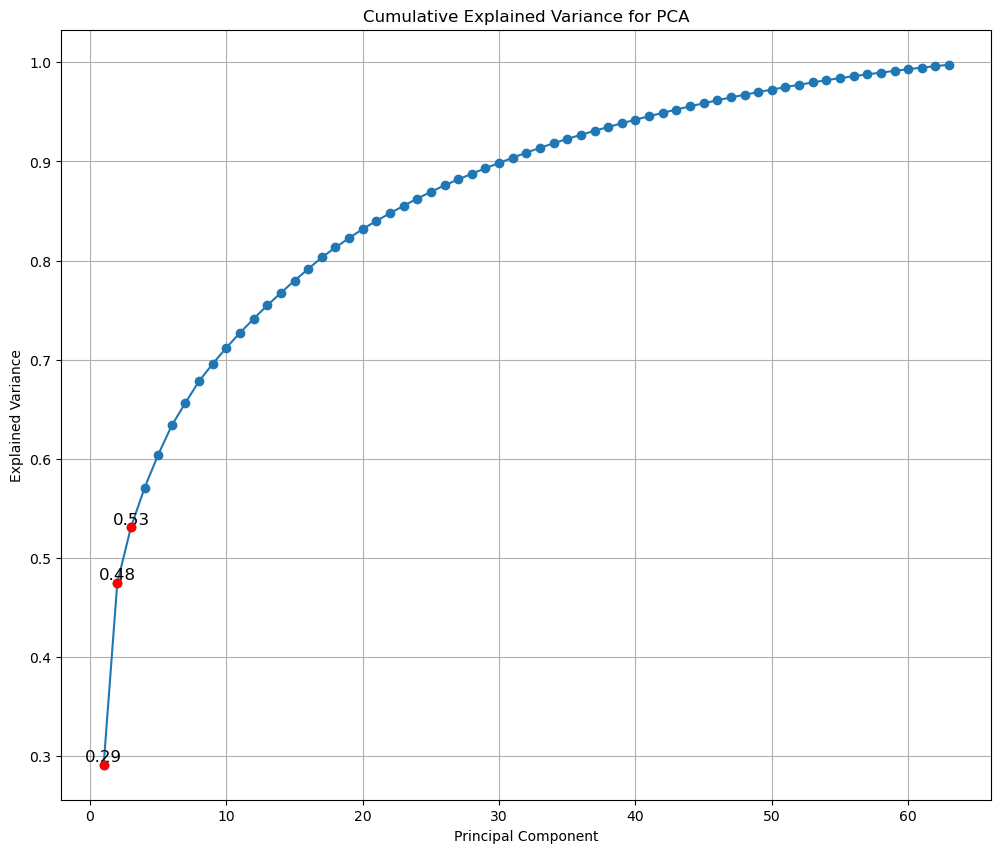

In [353]:
# Plot cumulative explained variance
plt.figure(figsize=(12, 10))
plt.plot(range(1, 64), cumulative_sum, marker='o', scaley=True)

# Highlight the first three values
for i in range(3):
    plt.scatter(i+1, cumulative_sum[i], color='red', zorder=5)
    plt.text(i+1, cumulative_sum[i], f'{cumulative_sum[i]:.2f}', fontsize=12, ha='center', va='bottom')

# Labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Cumulative Explained Variance for PCA')
plt.grid(True)
plt.show()

While PC1 and PC2 capture a large portion of the variance, the contributions of subsequent PCs decrease rapidly, indicating diminishing returns in terms of variance explained.

To achieve around 90% of the explained variance, more than 30 PCs are needed. This suggests a high dimensionality in the data, with many PCs required to capture most of the variance.

In [351]:
single_tree = best_rf.estimators_[0]

In [ ]:
#import graphviz
#from sklearn.tree import export_graphviz

In [ ]:
#code used in google collab to generate the graph, saved in docs/figures
#DOT data
#dot_data = tree.export_graphviz(single_tree, out_file=None, 
                                #feature_names=feature_names[:],  
                                #class_names=[str(i) for i in np.unique(y_train_rf)],
                                #filled=True,
                                #rounded=True,
                                #impurity=True)

# Render the decision tree into jpg
#graph = graphviz.Source(dot_data)
#graph.render("decision_tree", format="jpg", renderer='cairo' )



In [318]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=900)
plot_tree(single_tree, 
          feature_names=feature_names, 
          class_names=[str(i) for i in np.unique(y_train_rf)], 
          filled=True, 
          rounded=True,
          impurity=True,
          max_depth=4)
plt.show()

### Desicion Tree without PCA

In [319]:
X_3_ = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_3_= codon_df_clean['Kingdom']


X_train_rf_1, X_test_rf_1, y_train_rf_1, y_test_rf_1 = train_test_split(X_3_, y_3_, test_size=0.2, random_state=34)

In [320]:
scaler_RDF = StandardScaler()

scaler_RDF.fit(X_train_rf_1)

X_train_scaled_rf = scaler_RDF.transform(X_train_rf_1)
X_test_scaled_rf = scaler_RDF.transform(X_test_rf_1)

In [321]:
rf_model = RandomForestClassifier(random_state=34, n_estimators=350, max_depth=35, min_samples_leaf=1, min_samples_split=2)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=35, n_estimators=350, random_state=34)

In [322]:
y_pred_rf_1 = rf_model.predict(X_test_scaled_rf)

c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [323]:
accuracy_rf = accuracy_score(y_test_rf_1, y_pred_rf_1)
print(f'Accuracy: {accuracy_rf:.2f}')

Accuracy: 0.74


In [324]:
report_rf = classification_report(y_test_rf_1, y_pred_rf_1)
print(report_rf)

              precision    recall  f1-score   support

    animalia       0.72      0.89      0.79       872
     archaea       1.00      0.12      0.22        24
    bacteria       0.73      0.94      0.83       576
     plantae       0.72      0.78      0.75       518
       virus       0.92      0.32      0.48       612

    accuracy                           0.74      2602
   macro avg       0.82      0.61      0.61      2602
weighted avg       0.77      0.74      0.71      2602



The overall accuracy of the model is 74%, indicating it correctly predicts 74% of the instances in the test set.

Moderate precision but high recall for Animalia, indicating that while the model predicts Animalia instances well, there are some false positives.

100% precision but very low recall for Archaea, suggesting that while the model rarely misclassifies Archaea, it misses most of the actual instances.

High recall with moderate precision for Bacteria, indicating effective prediction with some false positives.

Balanced precision and recall for Plantae, suggesting consistent performance in predicting this class.

High precision but low recall for Virus Bacteriophage, indicating that while the model correctly identifies instances of this class, it misses many actual instances.

The Random Decision Tree model without PCA accuracy (74%) is lower than the other models.

Inspect feature importance, which tells which features were most influential in making predictions.

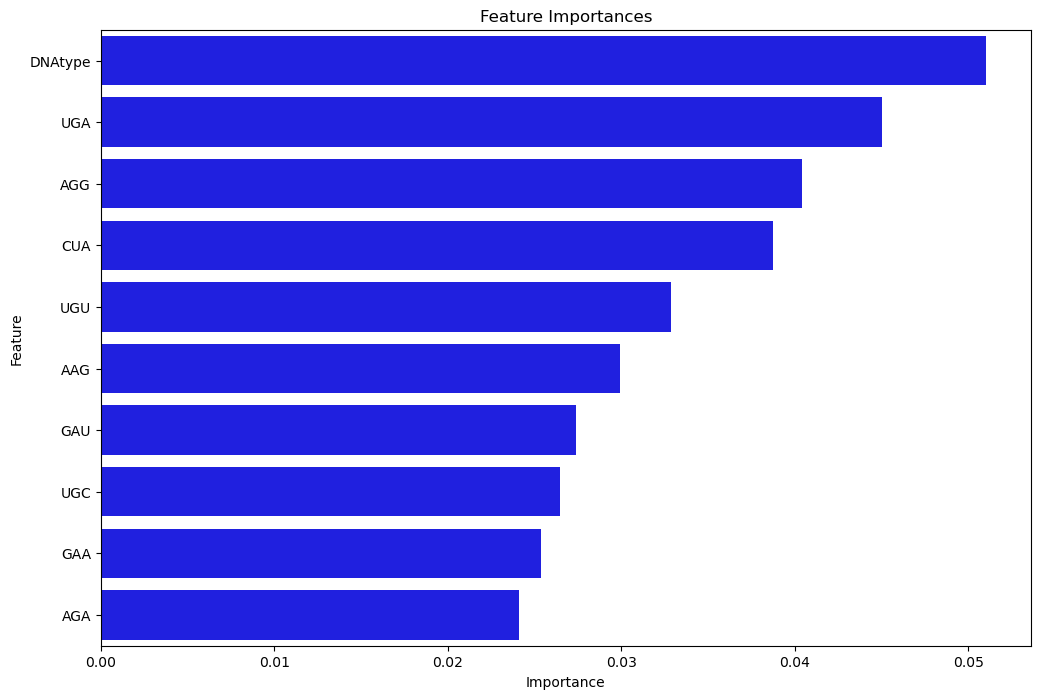

In [326]:
feature_importances = rf_model.feature_importances_
feature_names = X_3_.columns

# Creating a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='blue')
plt.title('Feature Importances')
plt.show()

The high importance of DNA type indicates that variations in DNA sequences play a critical role in classifying biological kingdoms. Different types of DNA sequences likely correlate with different biological characteristics that the model uses to make classifications.

Specific codons like UGA, AGG, CUA, and UGU are identified as key features. These codons are known to be important in genetic coding and may have significant biological implications that the model leverages for accurate predictions.

## Clustering

In [327]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [371]:
codon_df_sca = codon_df_clean.drop(columns=['Kingdom', 'SpeciesID', 'Ncodons', 'SpeciesName','DNAtype'])
codon_df_sca

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,0.03920,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,0.06386,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,0.06643,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,0.02082,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [372]:
codo_scaler = StandardScaler()
codon_df_scaled = codo_scaler.fit_transform(codon_df_sca)

Our target is divide by 10 classes or kingdoms. So as a test lets explore if using k as 10 will shown 10 clusters 

In [373]:
kmeans1 = KMeans(n_clusters= 10)
kmeans1_labels = kmeans1.fit_predict(codon_df_scaled)

agg1 = AgglomerativeClustering(n_clusters = 10 , linkage='ward')
agg1_labels = agg1.fit_predict(codon_df_scaled)

gmm1 = GaussianMixture(n_components = 10)
gmm1_labels = gmm1.fit_predict(codon_df_scaled)

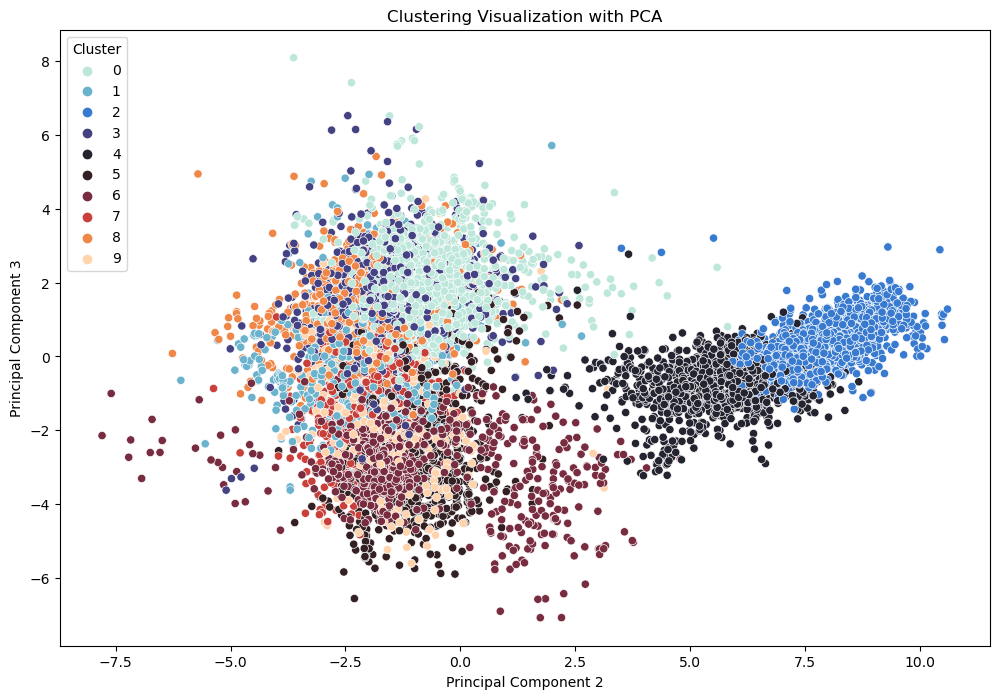

In [381]:
pca_clustering = PCA(n_components=10)
principal_components = pca_clustering.fit_transform(codon_df_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:, 1], y=principal_components[:,2 ], hue=kmeans1_labels, palette='icefire', legend='full')
plt.title('Clustering Visualization with PCA')

plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.legend(title='Cluster', loc='best')

plt.show()

Two distinct clusters are clearly discernible in the data. On the right side, there is a grouping comprising eight clusters belonging to the first cluster, while the second cluster is represented by two distinct groups.

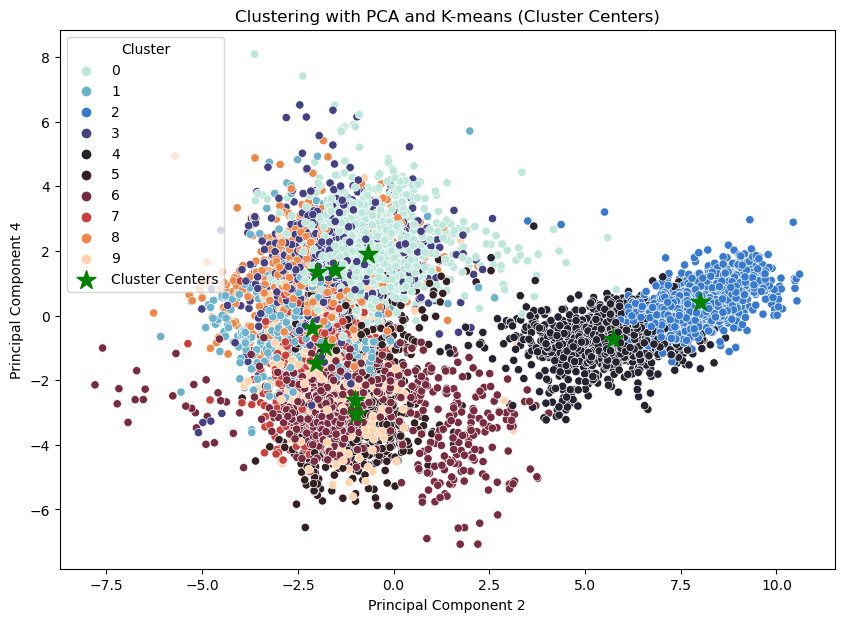

In [383]:
cluster_centers_pca = pca_clustering.transform(kmeans1.cluster_centers_)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=principal_components[:, 1], y=principal_components[:, 2], hue=kmeans1_labels, palette='icefire', legend='full')
plt.scatter(cluster_centers_pca[:, 1], cluster_centers_pca[:, 2], marker='*', color='green', s=200, label='Cluster Centers')
plt.title('Clustering with PCA and K-means (Cluster Centers)')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')
plt.legend(title='Cluster', loc='best')
plt.show()

In [333]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [334]:
silhouette_avg_kmeans = silhouette_score(codon_df_scaled, kmeans1_labels)
print(f"Silhouette Score for K-means clustering: {silhouette_avg_kmeans}")

silhouette_avg_agg = silhouette_score(codon_df_scaled, agg1_labels)
print(f"Silhouette Score for Agglomerative clustering: {silhouette_avg_agg}")

silhouette_avg_gmm = silhouette_score(codon_df_scaled, gmm1_labels)
print(f"Silhouette Score for Gaussian Mixture clustering: {silhouette_avg_gmm}")


Silhouette Score for K-means clustering: 0.13944726591863257
Silhouette Score for Agglomerative clustering: 0.12462036478294249
Silhouette Score for Gaussian Mixture clustering: 0.08972198338782437


The differences in silhouette scores between these methods are relatively small, indicating that all three algorithms perform similarly on the dataset in terms of clustering quality based on silhouette analysis.

In [335]:
from sklearn.metrics import rand_score

In [336]:
print(f'This is the rand score for kmeans and agg {rand_score(kmeans1_labels, agg1_labels)}')
print(f'This is the rand score for kmeans and gmm {rand_score(kmeans1_labels, gmm1_labels)}')

This is the rand score for kmeans and agg 0.8793675862490923
This is the rand score for kmeans and gmm 0.870284283011201


The Rand score of approximately 0.87 and 0.86 indicates a high level of agreement or similarity between the clusterings produced by K-means and Agglomerative Clustering and K-means and Gaussian Mixture Model. This suggests that the two clustering algorithms data points to clusters in a very similar manner.

Using k=10 didnt shown 10 clusters, therefore lets find the best k for this dataset

In [337]:
silScoreKmeans = []
silScoresGauss =[]
silScoresAgglom =[]

ks = np.arange(2,11)

for k in ks:

    print(f'currently working on kmeans with k={k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(codon_df_scaled)
    kmeans_score = silhouette_score(codon_df_scaled, kmeans.labels_)
    silScoreKmeans.append(kmeans_score)

    print(f'currently working on gmm with k={k}')
    gmm = GaussianMixture(n_components=k)
    gmm.fit(codon_df_scaled)
    gmm_score = silhouette_score(codon_df_scaled, gmm.predict(codon_df_scaled))
    silScoresGauss.append(gmm_score)

    #fit hierarchichal (agglomerative)
    print(f'currently working on agg with k={k}')
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(codon_df_scaled)
    agg_score = silhouette_score(codon_df_scaled, agg.labels_)
    silScoresAgglom.append(agg_score)

currently working on kmeans with k=2
currently working on gmm with k=2
currently working on agg with k=2
currently working on kmeans with k=3
currently working on gmm with k=3
currently working on agg with k=3
currently working on kmeans with k=4
currently working on gmm with k=4
currently working on agg with k=4
currently working on kmeans with k=5
currently working on gmm with k=5
currently working on agg with k=5
currently working on kmeans with k=6
currently working on gmm with k=6
currently working on agg with k=6
currently working on kmeans with k=7
currently working on gmm with k=7
currently working on agg with k=7
currently working on kmeans with k=8
currently working on gmm with k=8
currently working on agg with k=8
currently working on kmeans with k=9
currently working on gmm with k=9
currently working on agg with k=9
currently working on kmeans with k=10
currently working on gmm with k=10
currently working on agg with k=10


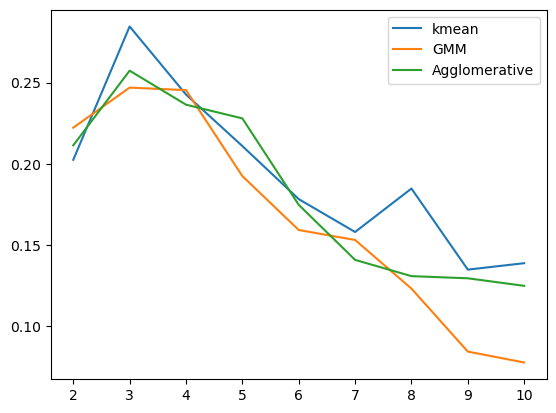

In [338]:
plt.figure()
plt.plot(ks, silScoreKmeans, label='kmean')
plt.plot(ks, silScoresGauss, label='GMM')
plt.plot(ks, silScoresAgglom, label='Agglomerative')
plt.legend()
plt.show()

In [339]:
kmeans2 = KMeans(n_clusters=3)
kmeans2_labels = kmeans2.fit_predict(codon_df_scaled)

agg2 = AgglomerativeClustering(n_clusters = 3, linkage='ward')
agg2_labels = agg2.fit_predict(codon_df_scaled)

gmm2 = GaussianMixture(n_components = 3)
gmm2_labels = gmm2.fit_predict(codon_df_scaled)

In [340]:
silhouette_avg_kmeans2 = silhouette_score(codon_df_scaled, kmeans2_labels)
print(f"Silhouette Score for K-means clustering: {silhouette_avg_kmeans2}")

silhouette_avg_agg2 = silhouette_score(codon_df_scaled, agg2_labels)
print(f"Silhouette Score for Agglomerative clustering: {silhouette_avg_agg2}")

silhouette_avg_gmm2 = silhouette_score(codon_df_scaled, gmm2_labels)
print(f"Silhouette Score for Gaussian clustering: {silhouette_avg_gmm2}")

Silhouette Score for K-means clustering: 0.2852724676778814
Silhouette Score for Agglomerative clustering: 0.2574084513816836
Silhouette Score for Gaussian clustering: 0.2469527203925215


In [341]:
print(f'This is the rand score with k= 3 for kmeans and agg: {rand_score(kmeans2_labels, agg2_labels)}')
print(f'This is the rand score with k= 3 for kmeans and gaussian clustering: {rand_score(kmeans2_labels, gmm2_labels)}')

This is the rand score with k= 3 for kmeans and agg: 0.7170129250112367
This is the rand score with k= 3 for kmeans and gaussian clustering: 0.8064988021872223


The clustering results from k-means and agglomerative clustering are moderately similar. A Rand score of 0.7170 indicates that about 71.7% of the decisions (whether pairs of samples are in the same cluster or not) are in agreement between the two clustering methods. While this is a reasonably high similarity, it also indicates that there are notable differences in how these methods have grouped the data.

The clustering results from k-means and Gaussian Mixture Models are quite similar. A Rand score of 0.8065 means that about 80.7% of the decisions are in agreement between the two methods. This higher Rand score suggests that k-means and GMMs produce more similar clusterings compared to k-means and agglomerative clustering.

The higher Rand score (0.8065) between k-means and Gaussian Mixture Models suggests that these two methods produce more similar clusterings for our data set, likely because both make similar assumptions about cluster shapes and distributions.

The lower Rand score (0.7170) between k-means and agglomerative clustering indicates moderate similarity but also notable differences. This is likely due to the different assumptions and methodologies used by agglomerative clustering compared to k-means.

## XGBOOST

In [342]:
from xgboost import XGBClassifier

In [343]:
X_xgb = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_xgb = codon_df_clean['Kingdom']


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=34)

In [344]:
scaler_xgb = StandardScaler()
X_train_xgb_scaled = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler_xgb.transform(X_test_xgb)

In [345]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_xgb_scaled, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [346]:
y_pred_xgb = xgb_model.predict(X_test_xgb_scaled)
print(classification_report(y_test_xgb, y_pred_xgb))

              precision    recall  f1-score   support

    animalia       0.96      0.97      0.96       872
     archaea       0.93      0.58      0.72        24
    bacteria       0.95      0.96      0.96       576
     plantae       0.96      0.93      0.94       518
       virus       0.94      0.96      0.95       612

    accuracy                           0.95      2602
   macro avg       0.95      0.88      0.91      2602
weighted avg       0.95      0.95      0.95      2602



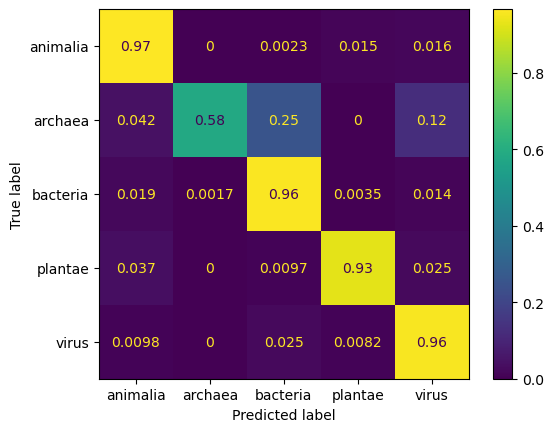

In [355]:
xgboost_test = confusion_matrix(y_test_xgb, y_pred_xgb)
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_xgb_scaled, y_test_xgb, normalize='true')

In [367]:
joblib.dump(xgb_model, '../model/XGBoost_model.pkl') 

['../model/XGBoost_model.pkl']

In [347]:
print(f"XG Boost score: {xgb_model.score(X_test_xgb_scaled, y_test_xgb)}")

XG Boost score: 0.9523443504996156


The overall accuracy of the XGBoost model is 95%.

Very high precision and recall for Animalia, indicating excellent prediction performance with minimal errors.

High precision but lower recall for Archaea, indicating accurate predictions when the model identifies them but misses some instances due to the small sample size.

High precision and recall for Bacteria, suggesting solid performance in predicting this class.

Very high precision and recall for Plantae, indicating accurate predictions with minimal errors.

High precision and recall for Virus Bacteriophage, suggesting effective classification performance.

The XGBoost model's accuracy (95%) is the highest among all the models tested, indicating superior overall performance.


In [348]:
cv_scores = cross_val_score(XGBClassifier(), X_xgb, y_xgb, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.84089162 0.93658724 0.96733282 0.95847751 0.88389081]
Mean cross-validation score: 0.9174360006394986


The cross-validation scores obtained for your XGBoost model indicate its consistency and reliability across different folds of our dataset. 

In other words the high mean score indicates that the XGBoost model is likely to generalize well to new, unseen data from the same distribution.

In [349]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [350]:
ensemble_model = VotingClassifier(estimators=[
    ('xgb', XGBClassifier()),
    ('lr', LogisticRegression(max_iter=1000)),
    ('svc', SVC())
], voting='hard')

ensemble_model.fit(X_train_xgb_scaled, y_train_xgb)
print(f"Ensemble model score: {ensemble_model.score(X_test_xgb_scaled, y_test_xgb)}")

y_pred_ensemble = ensemble_model.predict(X_test_xgb_scaled)
print(classification_report(y_test_xgb, y_pred_ensemble))

Ensemble model score: 0.9496541122213682
              precision    recall  f1-score   support

    animalia       0.96      0.96      0.96       872
     archaea       1.00      0.67      0.80        24
    bacteria       0.95      0.97      0.96       576
     plantae       0.96      0.92      0.94       518
       virus       0.93      0.95      0.94       612

    accuracy                           0.95      2602
   macro avg       0.96      0.89      0.92      2602
weighted avg       0.95      0.95      0.95      2602



In [368]:
joblib.dump(ensemble_model, '../model/Ensemble_model.pkl') 

['../model/Ensemble_model.pkl']

The ensemble model’s performance (95% accuracy) is comparable to or slightly better than the individual models (XGBoost, Logistic Regression, SVC) previously tested.

The ensemble approach combines the strengths of multiple models, often resulting in improved overall performance compared to individual models.

Given the high accuracy and balanced metrics across classes, the ensemble model appears robust and reliable for classifying biological kingdoms based on codon frequencies.

## Conclusion

After evaluating multiple classification models on the task of predicting biological kingdoms based on codon frequencies, the following insights and conclusions can be explain:

Gaussian Naive Bayes tends to capture as many instances as possible (high recall) at the expense of precision (more false positives). It is particularly weak in predicting Archaea correctly and struggles with precision across multiple classes.

Logistic Regression shows substantial improvement in all metrics compared to Gaussian Naive Bayes. The use of PCA and logistic regression provides a robust and reliable performance across most classes, though Archaea still presents some challenges due to its small sample size.

The KNN model outperforms both Gaussian Naive Bayes and Logistic Regression. It leverages distance metrics effectively, especially with the Manhattan distance metric and the chosen parameters, to classify instances with high accuracy and reliability.

The Random Forest model performs well across all classes, though Archaea remains a challenging class due to its low recall. The model benefits from the combination of PCA and Random Forest, capturing the most informative features effectively. Additionally, the model without PCA performs significantly lower than other models, particularly struggling with the recall for Virus Bacteriophage and Archaea.

XGBoost demonstrates the highest performance among all models tested, showing high accuracy and balanced metrics across all classes. The ensemble approach of XGBoost proves to be robust and reliable.


Overall, XGBoost with 95% accuracy and balanced performance across all classes. KNN, also performs exceptionally well with 96% accuracy, leveraging non-linear decision-making capabilities and Logistic Regression offers a substantial improvement over Gaussian Naive Bayes, particularly with PCA for dimensionality reduction.



| Model                 | Parameters                                                                                                               | Score | Precision (Average) | Recall (Average) |
|-----------------------|--------------------------------------------------------------------------------------------------------------------------|-------|---------------------|------------------|
| GaussianNB            | StandarScaler                                                                                                            | 65%   | 62%                 | 64%              |
| Logisti Regression    | StandarScaler, PCA = 63, C = 1, cv =5                                                                                    | 90%   | 89%                 | 86%              |
| KNN                   | StandarScaler, n_neighbors = 3, metric = manhattan, weights = distance, cv = 5                                           | 96%   | 95%                 | 94%              |
| Random Forest(PCA)    | StandarScaler, n_components = 64, max_depth = 35, min_sample_leaf = 1, min_sample_split = 2, n_estimators = 350,  cv = 5 | 94%   | 95%                 | 85%              |
| Random Forest(No PCA) | StandarScaler, max_depth = 35,  min_sample_leaf = 1, min_sample_split = 2, n_estimators = 350,  cv = 5                   | 74%   | 82%                 | 61%              |
| XGBoost               |                                                                                                                          | 95%   | 95%                 | 88%              |
| Ensamble Model        | XGBoost, Logistic Regression, SVC, voting = hard                                                                         | 95%   | 96%                 | 89%              |


